In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neurodsp.plts.time_series import plot_time_series

from ecephys.graham import channel_groups, paths
from ecephys.helpers.utils import load_df_h5
from ecephys.plot import plot_hypnogram_overlay
from ecephys.scoring import load_visbrain_hypnogram
from ecephys.sglx_utils import load_timeseries
from ecephys.signal.ripples import get_epoched_ripple_density
from ecephys.signal.timefrequency import get_bandpower, parallel_spectrogram_welch

In [3]:
condition = "BL"
subject = "Segundo"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000000


(-352.41983999999997, 7544.99584)

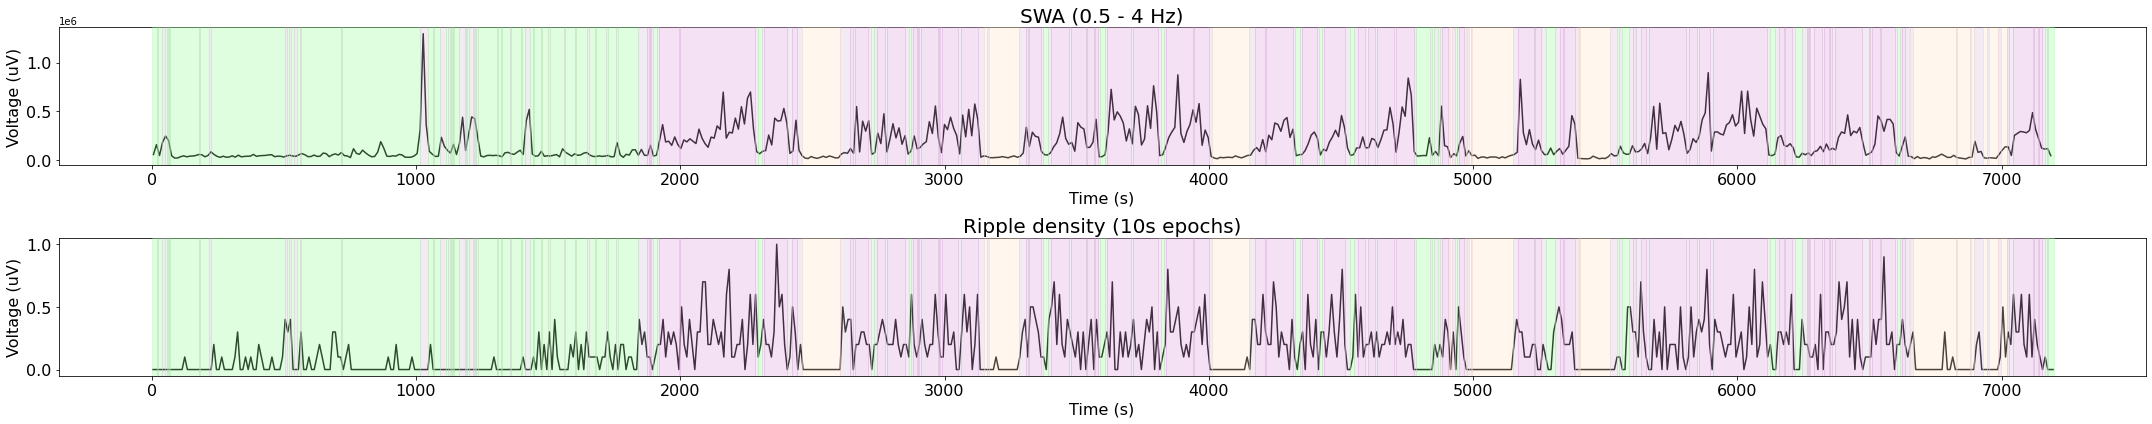

In [4]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [8]:
condition = "pre-SR"
subject = "Segundo"

#hypnogram_path = Path(paths.hypnograms[condition][subject])
#hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000001


(-352.41983999999997, 7544.99584)

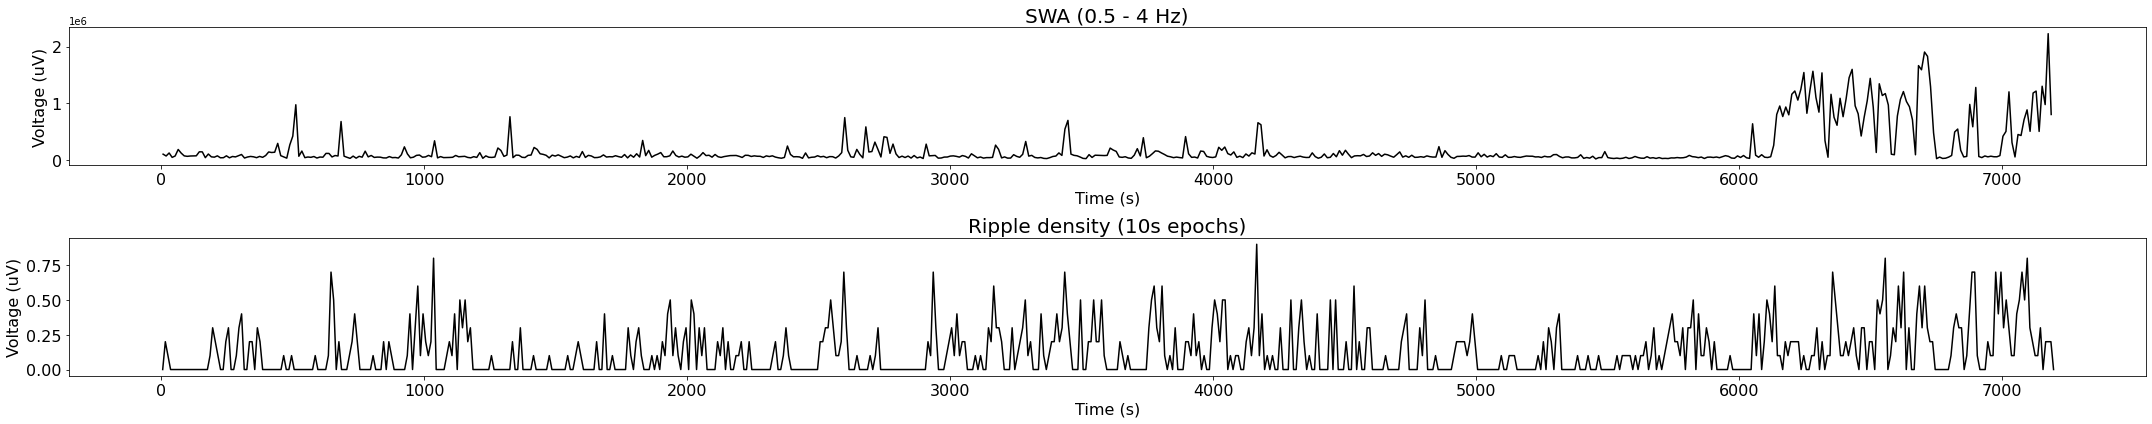

In [9]:
epochs = get_epoched_ripple_density(np.min(times), np.max(times), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
#plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
#plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [ ]:
# Segundo's recovery sleep starts at 1:42:28 = 6148 seconds into t22

In [5]:
condition = "SR"
subject = "Segundo"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000001


(-352.41983999999997, 7544.99584)

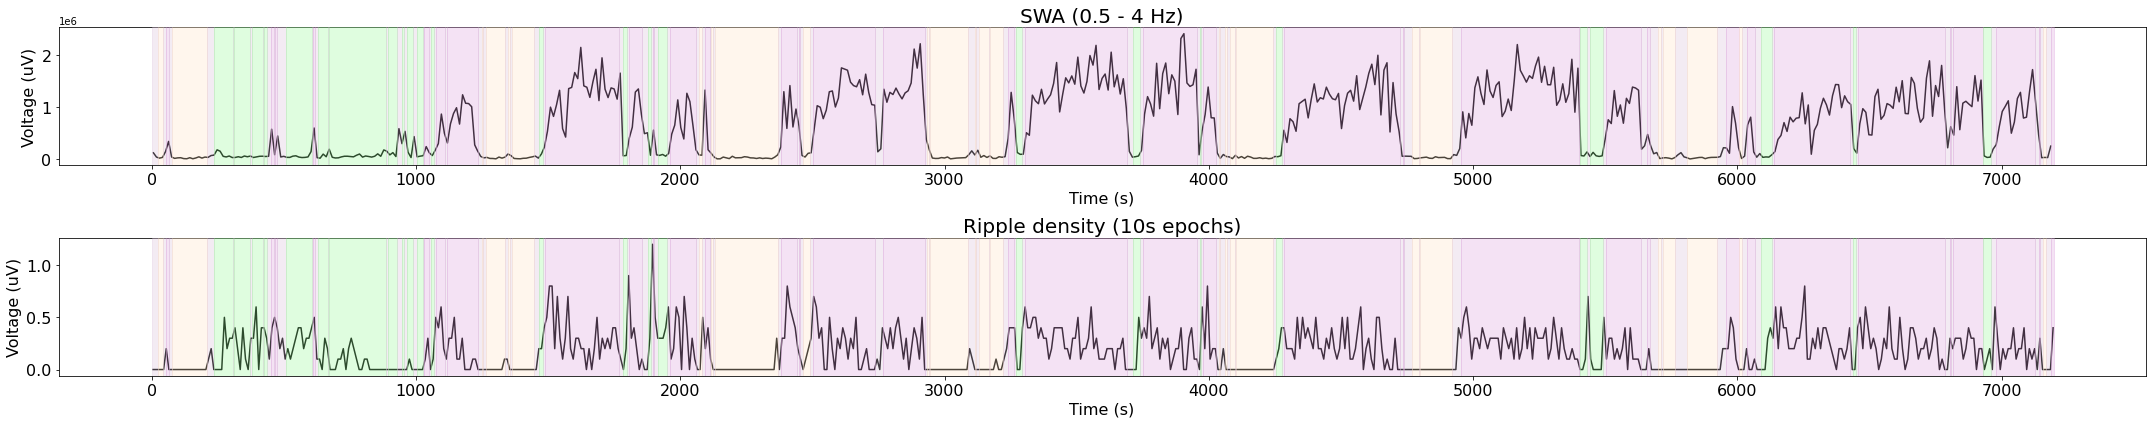

In [6]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [7]:
condition = "BL"
subject = "Valentino"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000000


(-352.41983999999997, 7544.99584)

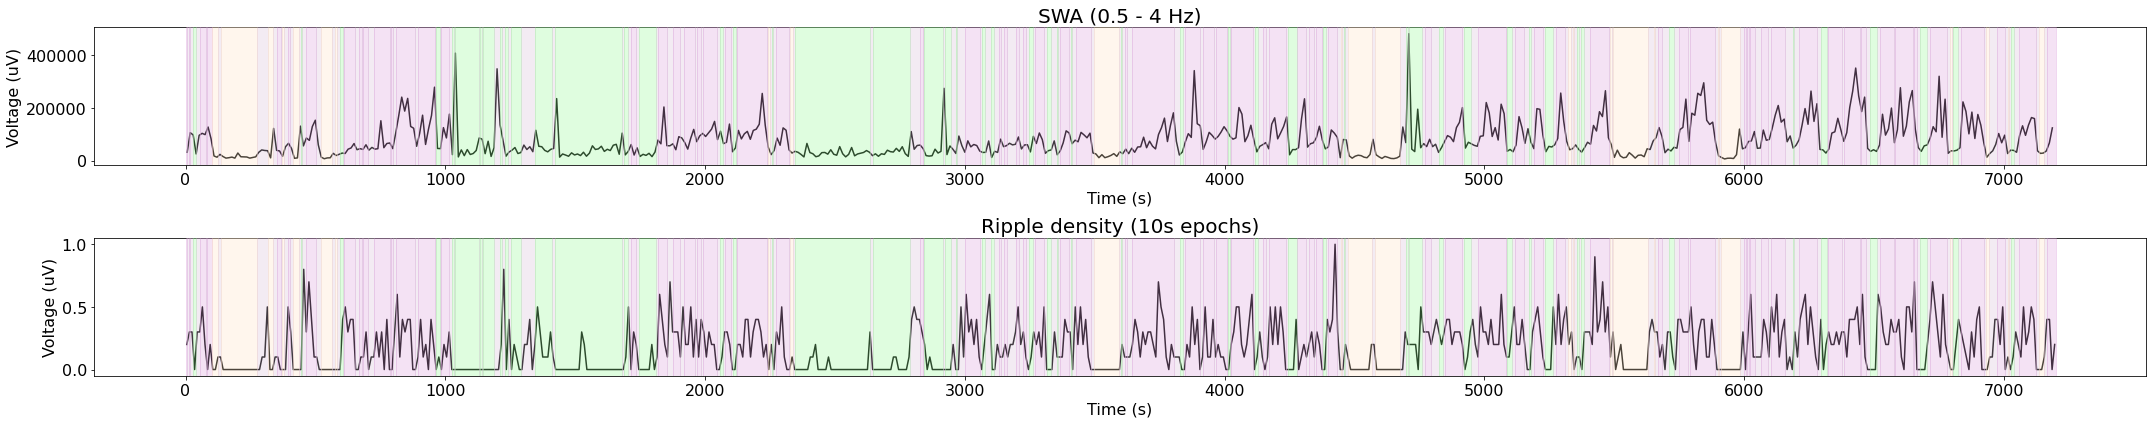

In [8]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [15]:
condition = "pre-SR"
subject = "Valentino"

#hypnogram_path = Path(paths.hypnograms[condition][subject])
#hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000000


(-352.41983999999997, 7544.99584)

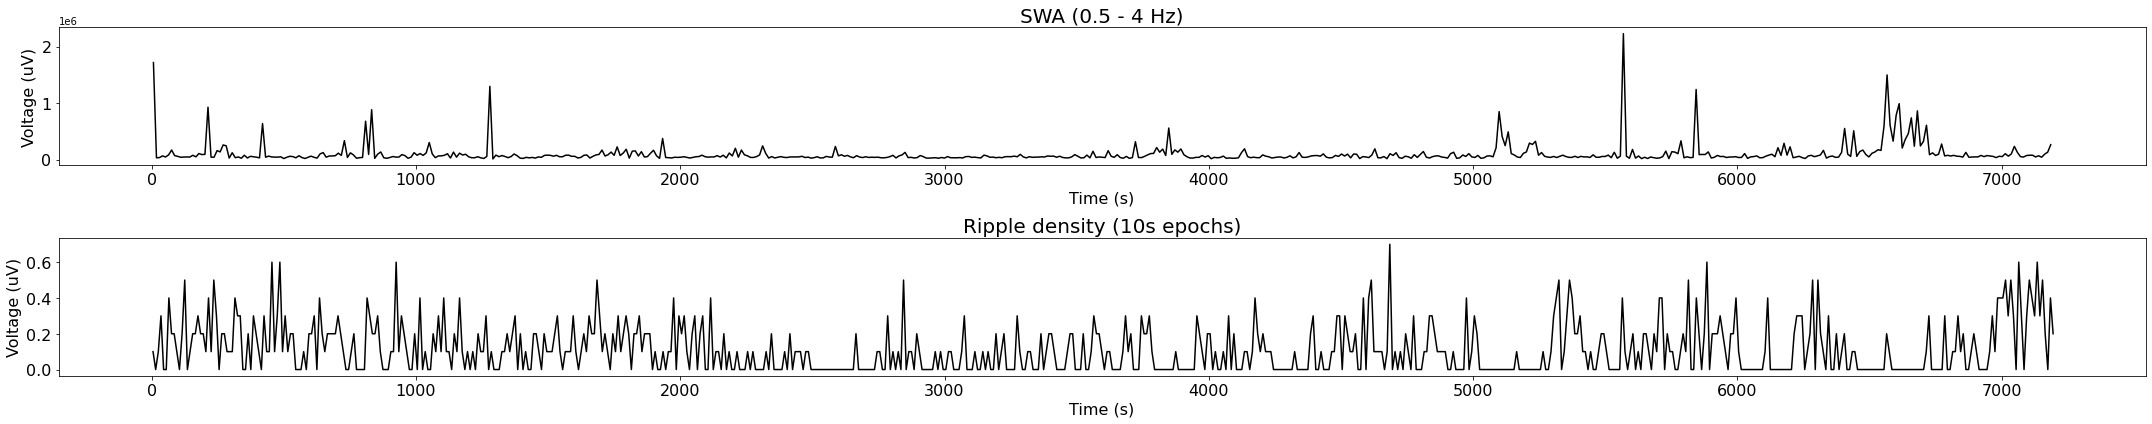

In [16]:
epochs = get_epoched_ripple_density(np.min(times), np.max(times), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
#plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
#plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [9]:
condition = "SR"
subject = "Valentino"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000000


(-352.41983999999997, 7544.99584)

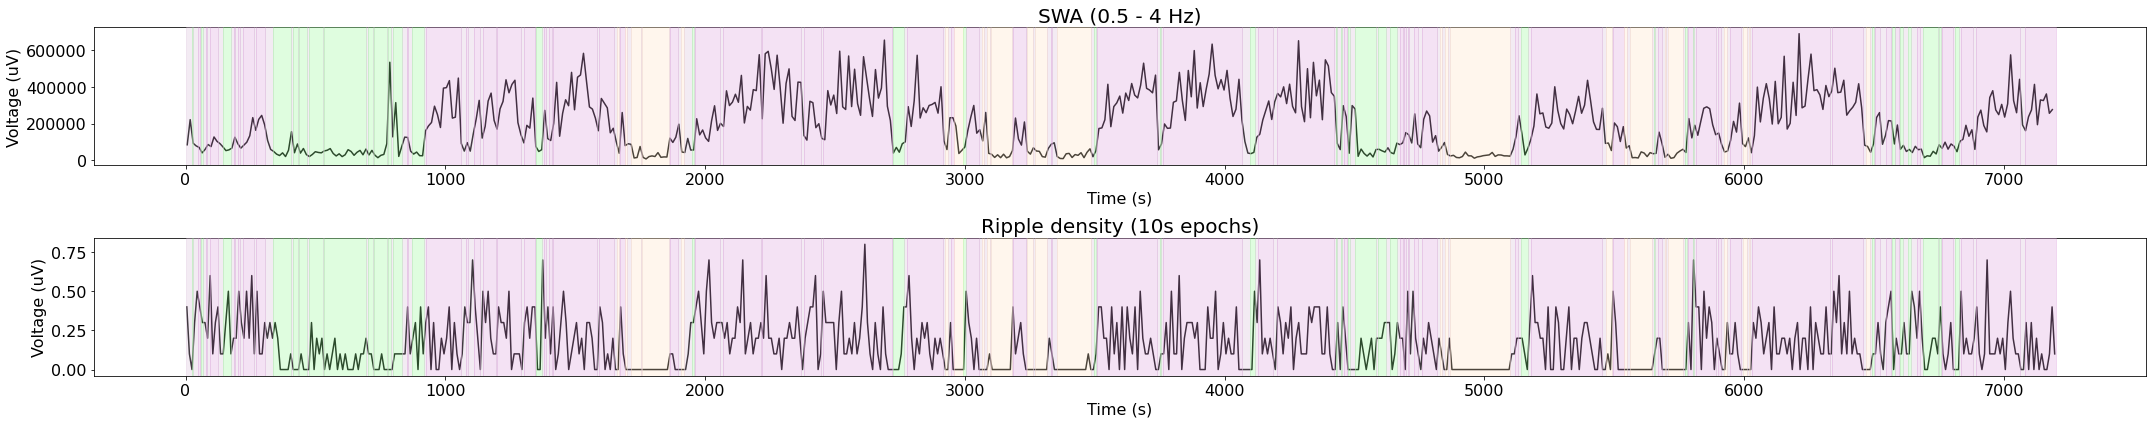

In [10]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [13]:
condition = "BL"
subject = "Doppio"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

(-352.4194856069653, 7544.988252759812)

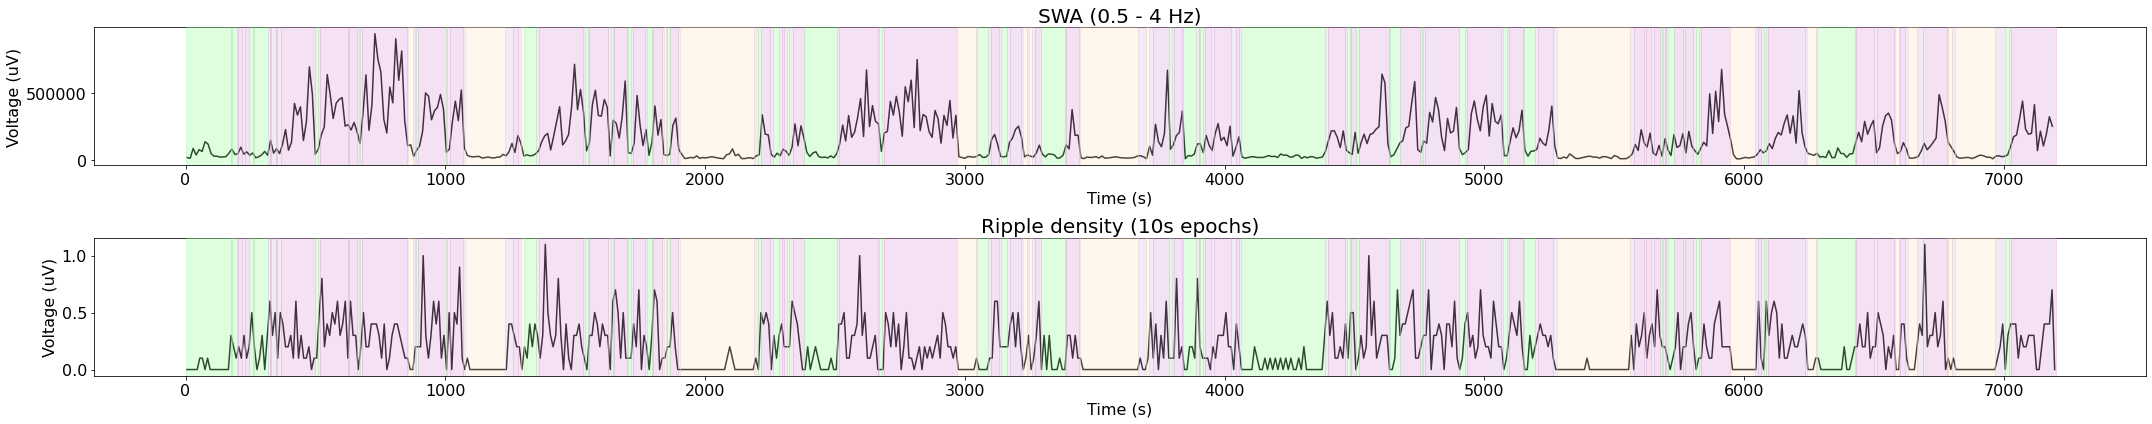

In [26]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [6]:
condition = "pre-SR"
subject = "Doppio"

#hypnogram_path = Path(paths.hypnograms[condition][subject])
#hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000019


(-352.4194856069653, 7544.988252759812)

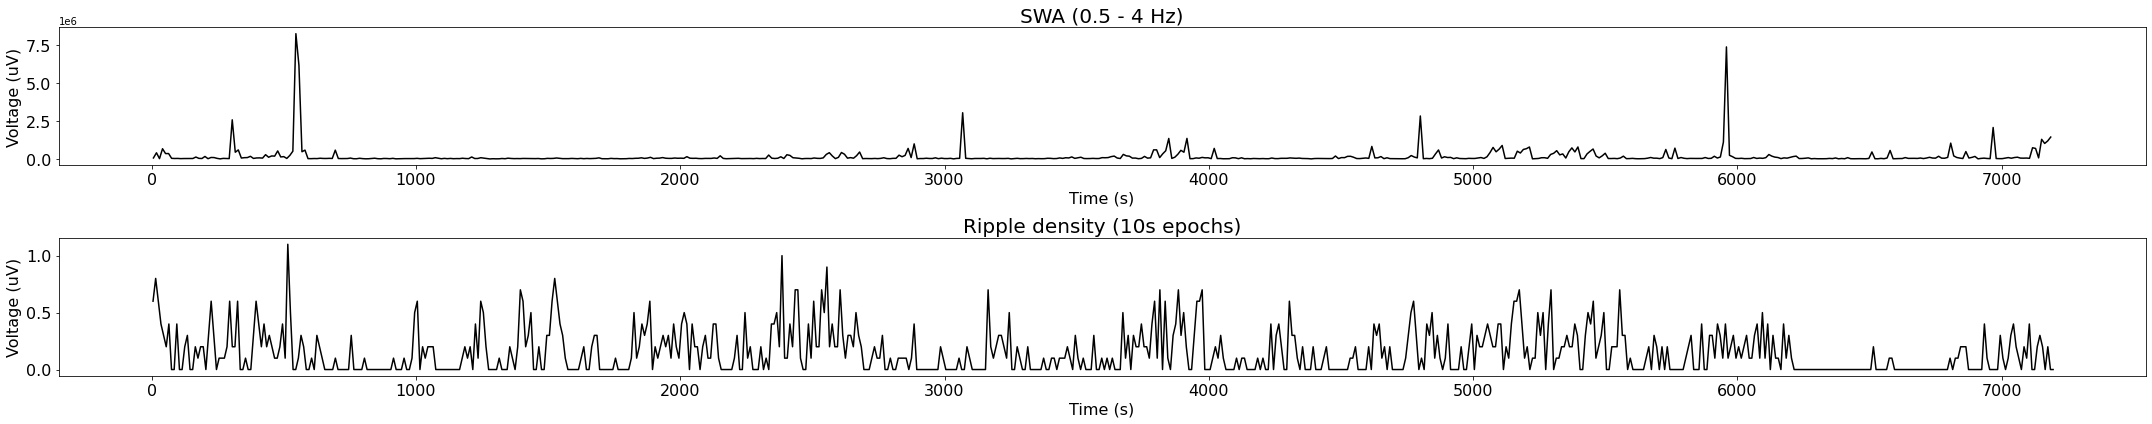

In [7]:
epochs = get_epoched_ripple_density(np.min(times), np.max(times), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
#plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
#plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [27]:
condition = "SR"
subject = "Doppio"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 18000019


(-352.4194856069653, 7544.988252759812)

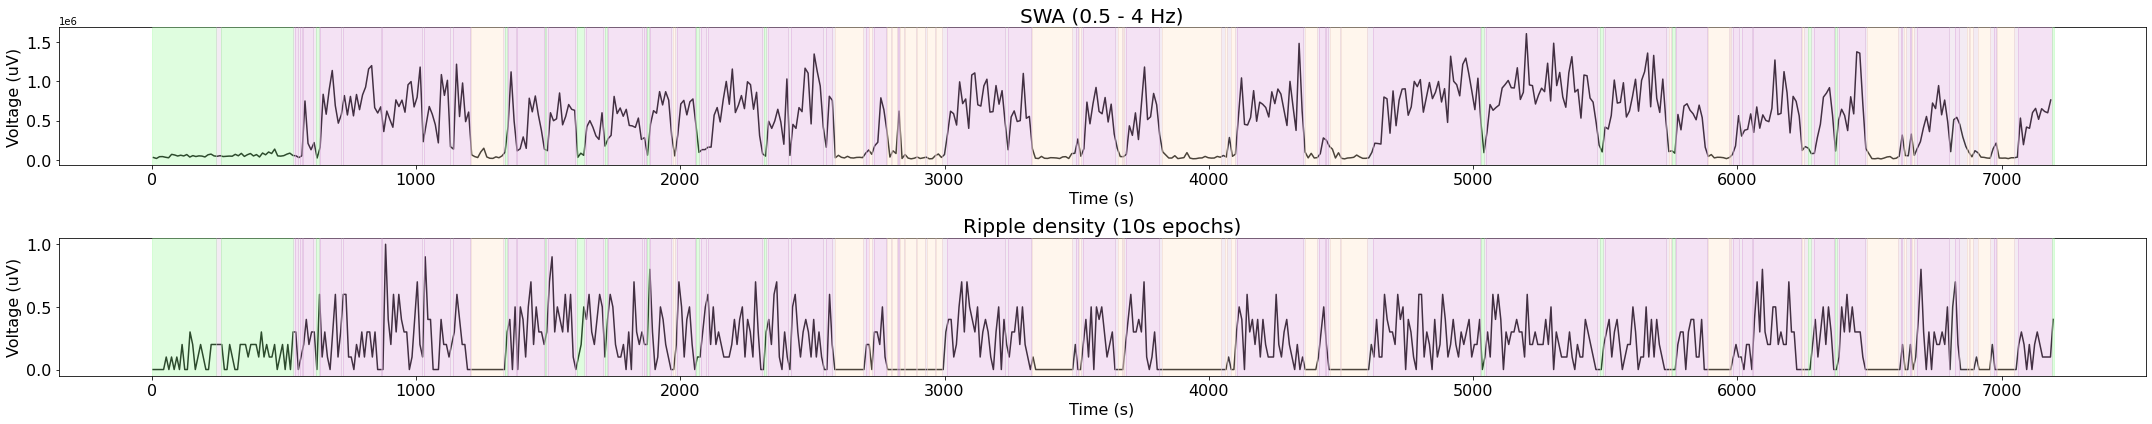

In [28]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [11]:
condition = "BL"
subject = "Alessandro"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 9000052


(-172.35870538046458, 3763.7111977186614)

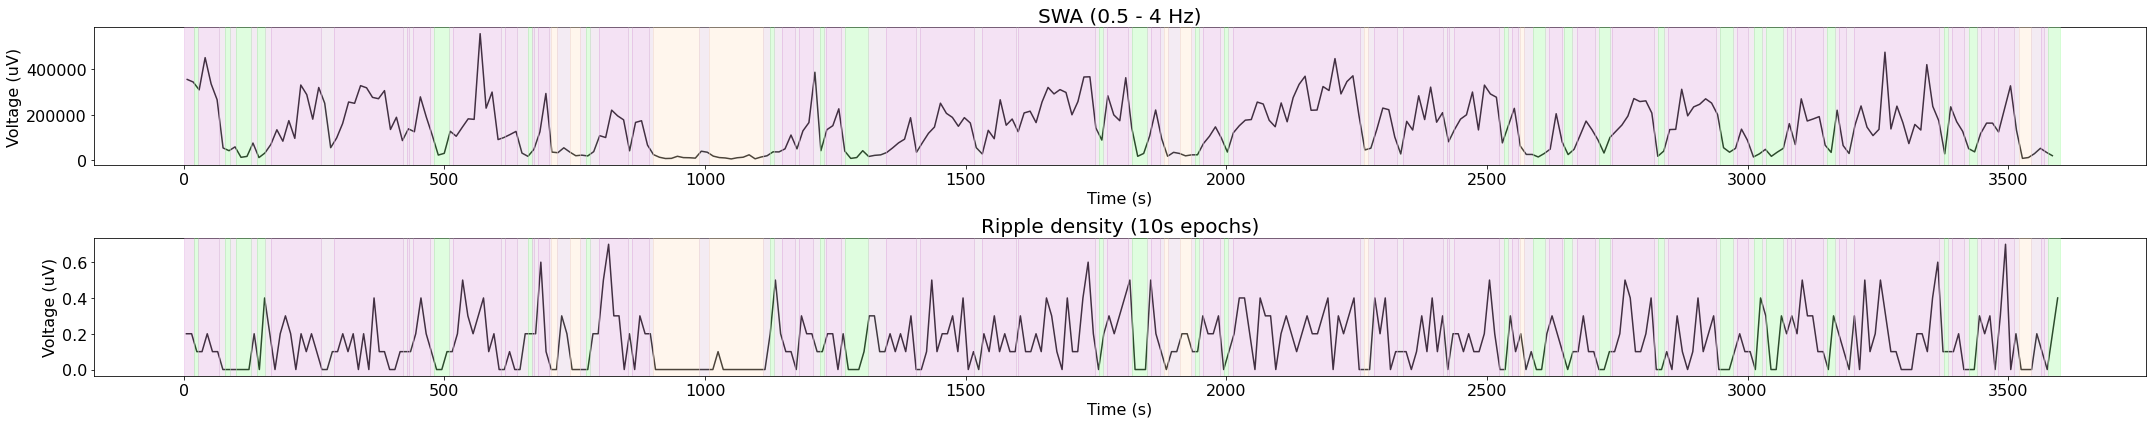

In [12]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [13]:
condition = "SR"
subject = "Alessandro"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 9000052


(-172.35870538046458, 3763.7111977186614)

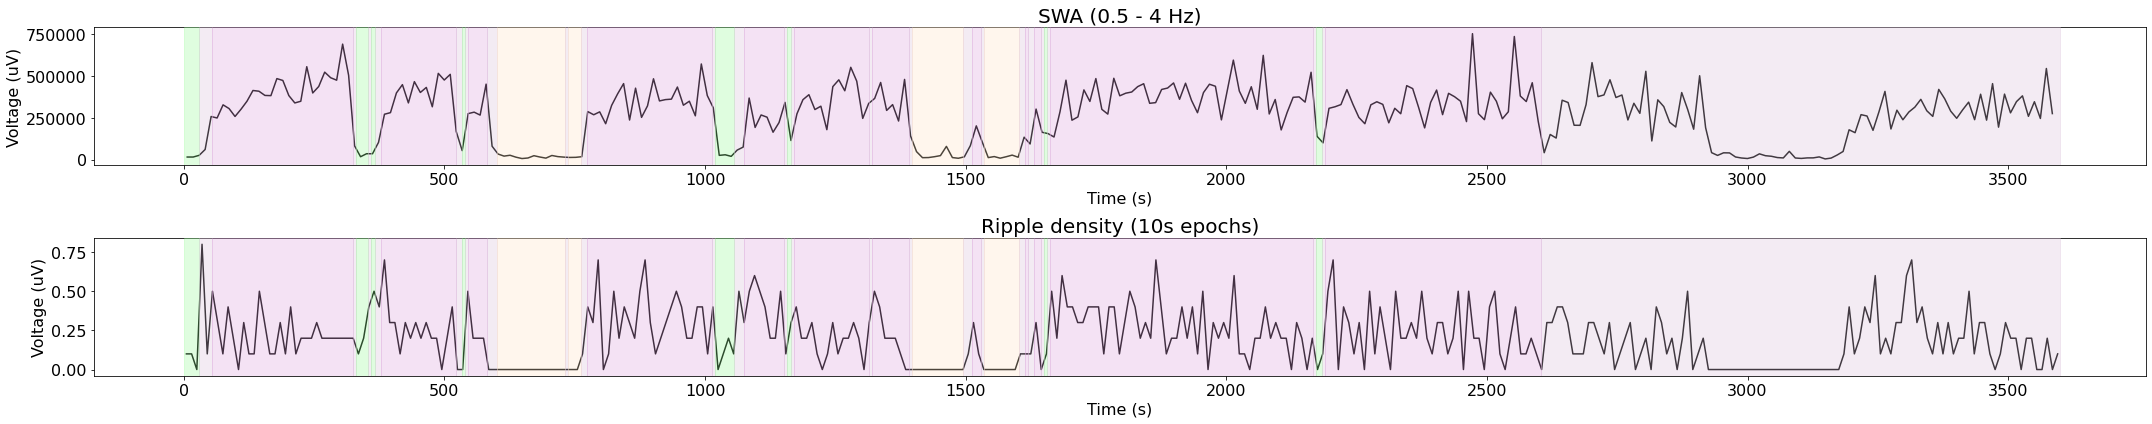

In [14]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [15]:
condition = "BL"
subject = "Eugene"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 9000025


(-172.35920309357567, 3763.7220660319576)

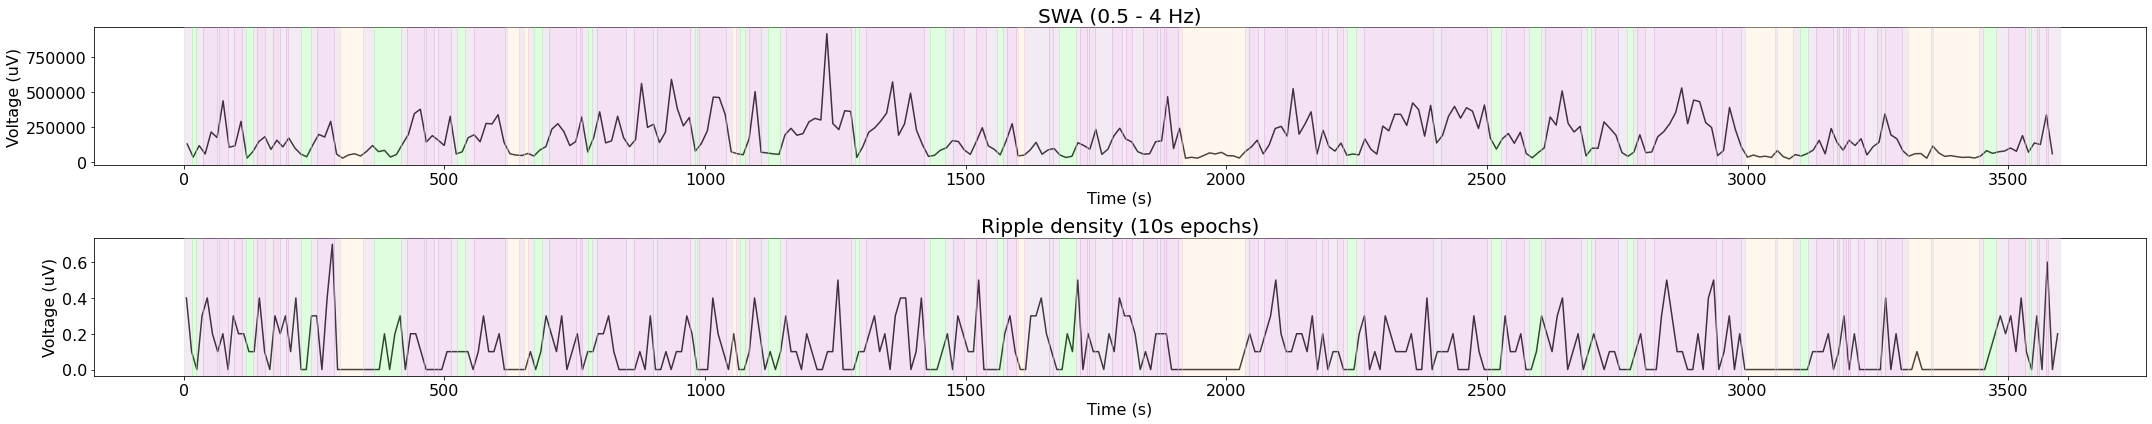

In [16]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())

In [17]:
condition = "SR"
subject = "Eugene"

hypnogram_path = Path(paths.hypnograms[condition][subject])
hypnogram = load_visbrain_hypnogram(hypnogram_path)

ripple_path = Path(paths.ripples[condition][subject])
with pd.HDFStore(ripple_path) as store:
    ripples, metadata = load_df_h5(store)

chans = channel_groups.superficial_ctx[subject]
bin_path = Path(paths.lfp_bin[condition][subject])
(times, sig, fs) = load_timeseries(bin_path, chans, start_time=None, end_time=None)

nChan: 385, nFileSamp: 9000026


(-172.35920309357567, 3763.7220660319576)

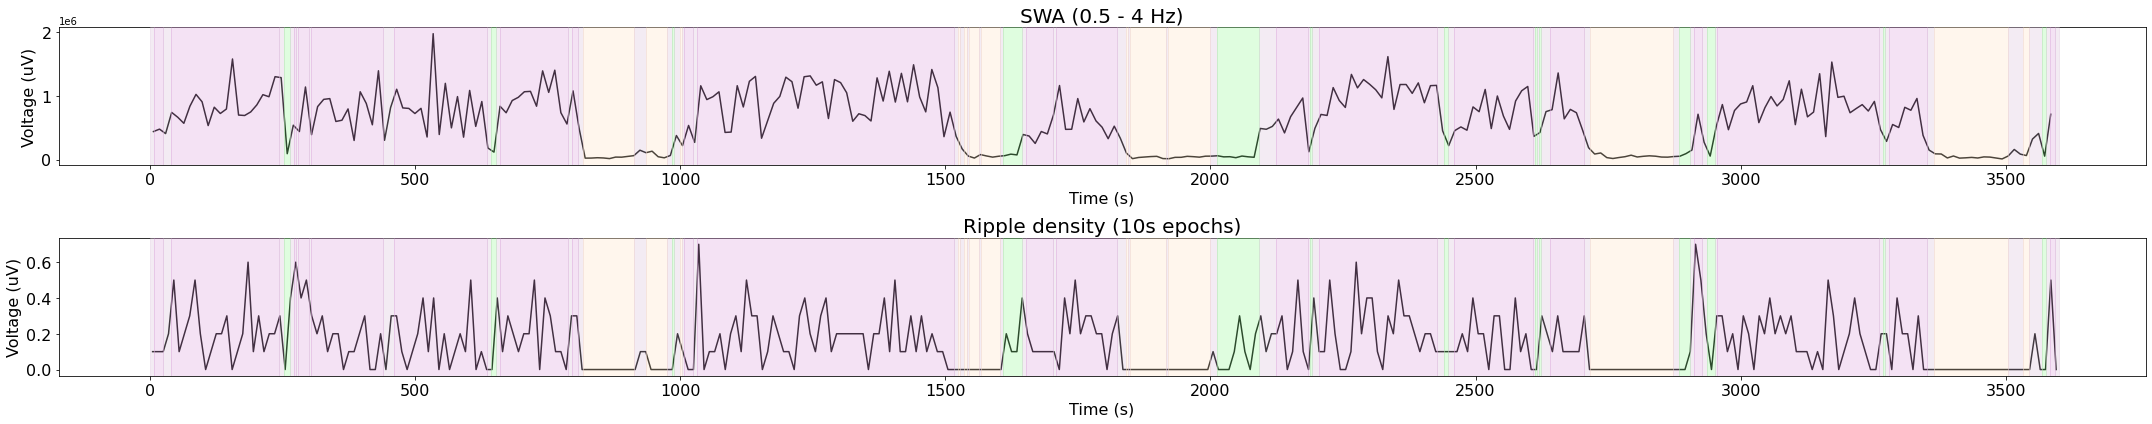

In [18]:
epochs = get_epoched_ripple_density(np.min(hypnogram.start_time), np.max(hypnogram.end_time), ripples.center_time, epoch_length=10)

freqs, spg_times, spg = parallel_spectrogram_welch(sig, fs, nperseg = 2 ** 15)
spg = np.median(spg, axis=-1)

swa = get_bandpower(freqs, spg_times, spg, f_range=(0.5, 4))

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6))
plot_time_series(spg_times, swa, ax=ax1, title="SWA (0.5 - 4 Hz)")
plot_hypnogram_overlay(hypnogram, ax=ax1)
plot_time_series(epochs.center_time.to_numpy(), epochs.ripple_density.to_numpy(), ax=ax2, title="Ripple density (10s epochs)")
plot_hypnogram_overlay(hypnogram, ax=ax2)
ax2.set_xlim(ax1.get_xlim())